In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

Melhor Modelo SARIMA - Ordem: (0, 1, 1), Ordem Sazonal: (1, 1, 1, 12), AIC: 721.9223006395717
SARIMA Mean Squared Error: 1208.6189221109871


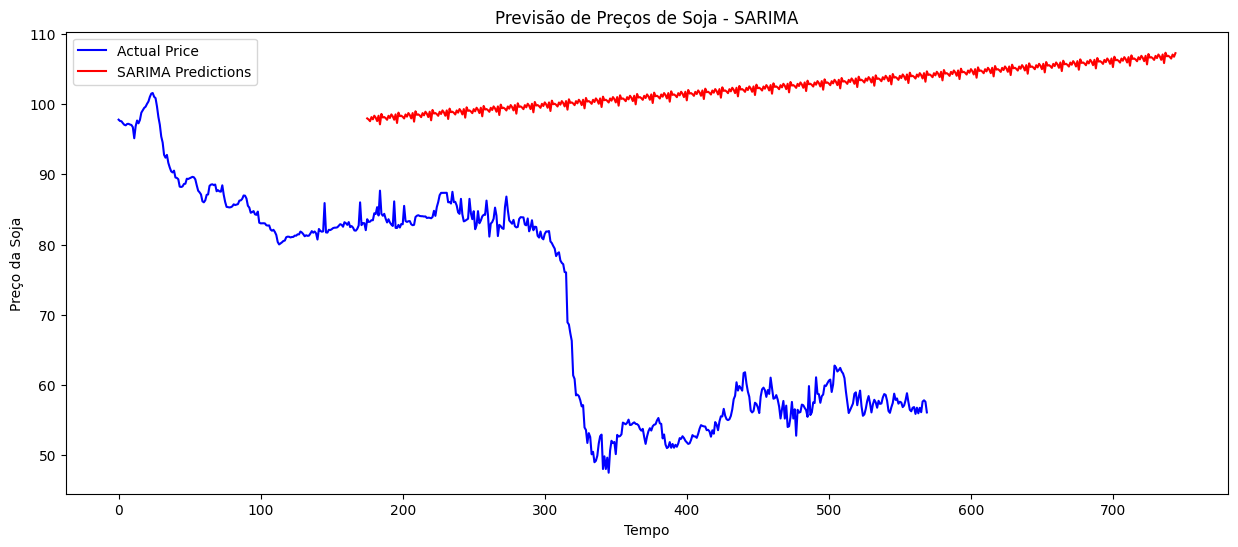

Previsão do próximo dia (2024-04-18 00:00:00): 97.94603698824308


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Carregar os dados
data = pd.read_csv('../data/soy/13/soy_prices.csv', parse_dates=['date'], index_col='date')

# Converter o tipo de preço
def convert_df_price_type(data):
    data["avg_price"] = data["avg_price"].astype(str).str.replace(',', '.').astype(float)
    return data

data = convert_df_price_type(data)

# Separar os dados de treinamento e teste
def separate_training_and_test_data(data):
    data_to_train = data[:175]
    data_to_test = data[175:]
    data_to_train.to_csv('train_data.csv')
    data_to_test.to_csv('test_data.csv')
    return data_to_train, data_to_test

train_data, test_data = separate_training_and_test_data(data)

# Função para buscar os melhores parâmetros SARIMA
def sarima_param_search(train_data):
    import itertools
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_model = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(train_data['avg_price'],
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                model_fit = model.fit(disp=False, maxiter=200)
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_model = model_fit
            except Exception as e:
                continue
    
    print(f"Melhor Modelo SARIMA - Ordem: {best_pdq}, Ordem Sazonal: {best_seasonal_pdq}, AIC: {best_aic}")
    return best_model

# Buscar os melhores parâmetros e ajustar o modelo SARIMA
best_sarima_model = sarima_param_search(train_data)

# Fazer previsões no conjunto de teste
start = len(train_data)
end = len(data) - 1
predictions_sarima = best_sarima_model.predict(start=start, end=end, dynamic=False)

# Calcular o erro da previsão (MSE)
mse_sarima = mean_squared_error(test_data['avg_price'], predictions_sarima)
print(f"SARIMA Mean Squared Error: {mse_sarima}")

# Plotar as previsões SARIMA versus valores reais
plt.figure(figsize=(15, 6))
plt.plot(test_data['avg_price'].values, label='Actual Price', color="blue")
plt.plot(predictions_sarima, label='SARIMA Predictions', color="red")
plt.title('Previsão de Preços de Soja - SARIMA')
plt.xlabel('Tempo')
plt.ylabel('Preço da Soja')
plt.legend()
plt.show()

# Previsão do próximo dia
next_day_prediction_sarima = best_sarima_model.forecast(steps=1)
predicted_date = test_data.index[-1] + pd.DateOffset(1)
print(f"Previsão do próximo dia ({predicted_date}): {next_day_prediction_sarima.iloc[0]}")